In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from sklearn import datasets

# Problem 1

In this problem we will look at image compression using SVD, following the lines of the well-known "Eigenfaces" experiment. The basic concept is to represent an image (in grayscale) of size $m \times n$ as an $m \times n$ real matrix $M$. SVD is then applied to this matrix to obtain $U$, $S$, and $V$ such that $M = U S V^T$. Here $U$ and $V$ are the matrices whose columns are the left and right singular vectors respectively, and $S$ is a diagonal $m \times n$ matrix consisting of the singular values of $M$. The number of non-zero singular values is the rank of $M$. By using just the largest $k$ singular values (and corresponding left and right singular vectors), one obtains the best rank-$k$ approximation to $M$.

The following code returns the dataset of 400 images.

In [16]:
data = datasets.fetch_olivetti_faces()
images = data.images

(a) Given an $m \times n$ image $M$ and its rank-$k$ approximation $A$, we can measure the reconstruction error using mean $\ell_1$ error: $$ \text{error}_{\ell_1}(M, A) = \frac{1}{mn}\| M - A \|_1 = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}| M_{i,j} - A_{i,j} |. $$ For $k = 1, \dots, 30$, take the average rank-$k$ reconstruction error over all images in the dataset, and plot a curve of average reconstruction error as a function of $k$.

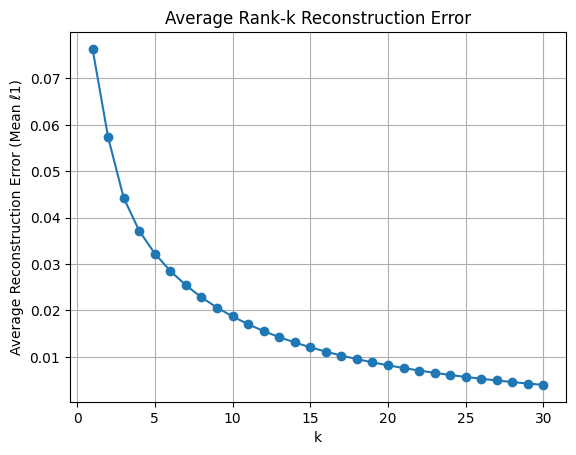

In [17]:
# Returns the best rank-k approximation to M
def svd_reconstruct(M, k):
    # Perform SVD on the matrix M
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    
    # Create a diagonal matrix for the top-k singular values
    S_k = np.diag(S[:k])
    
    # Reconstruct the matrix using the top-k components
    M_k = U[:, :k] @ S_k @ Vt[:k, :]
    
    return M_k

def mean_l1_error(M, A):
    return np.mean(np.abs(M - A))

max_k = 30
errors = np.zeros(max_k)

for k in range(1, max_k + 1):
    total_error = 0
    for image in images:
        M = image
        A_k = svd_reconstruct(M, k)
        total_error += mean_l1_error(M, A_k)
    
    # Average the error over all images
    errors[k-1] = total_error / len(images)

plt.plot(range(1, max_k + 1), errors, marker='o')
plt.xlabel('k')
plt.ylabel('Average Reconstruction Error (Mean ℓ1)')
plt.title('Average Rank-k Reconstruction Error')
plt.grid(True)
plt.show()

(b) Pick any image in the dataset, and display the following side-by-side as images: the original, and the best rank-$k$ approximations for $k = 10, 20, 30, 40$. You will find the `imshow` method in matplotlib useful for this; pass in `cmap='gray'` to render in grayscale. Feel free to play around further.

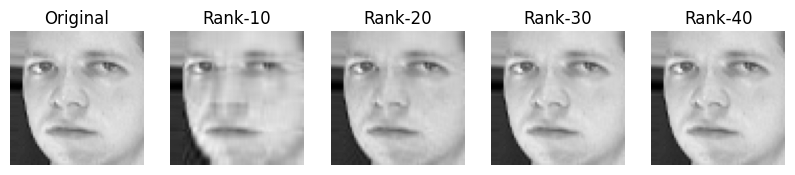

In [18]:
# Pick any image from the dataset (e.g., the first image)
image = images[5]

# Compute rank-k approximations
k_values = [10, 20, 30, 40]
approximations = [svd_reconstruct(image, k) for k in k_values]

# Plot the original and approximated images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')

# Approximations
for i, (k, approx) in enumerate(zip(k_values, approximations)):
    plt.subplot(1, len(k_values) + 1, i + 2)
    plt.imshow(approx, cmap='gray')
    plt.title(f'Rank-{k}')
    plt.axis('off')

plt.show()

# Problem 2

In this problem we visualize the Wisconsin breast cancer dataset in two dimensions using PCA. First, rescale the data so that every feature has mean 0 and standard deviation 1 across the various points in the dataset. You may find `sklearn.preprocessing.StandardScaler` useful for this. Next, compute the top two principal components of the dataset using PCA, and for every data point, compute its coordinates (i.e. projections) along these two principal components. You should do this in two ways:
1. By using SVD directly. Do not use any PCA built-ins.
2. By using `sklearn.decomposition.PCA`.

The two approaches should give exactly the same result, and this also acts as a check. (But note that the signs of the singular vectors may be flipped in the two approaches since singular vectors are only determined uniquely up to sign. If this happens, flip signs to make everything identical again.)

Your final goal is to make a scatterplot of the dataset in 2 dimensions, where the x-axis is the first principal component and the y-axis is the second. Color the points by their diagnosis (malignant or benign). Do this for both approaches. Your plots should be identical. Does the data look roughly separable already in 2 dimensions?

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
cancer = datasets.load_breast_cancer()

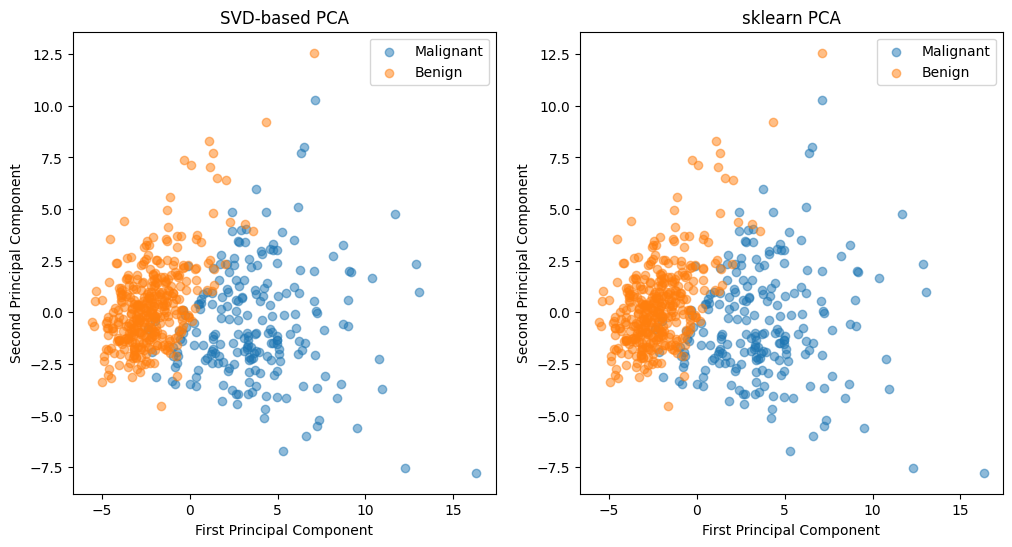

In [20]:
# Load the dataset
X = cancer.data  # feature matrix
y = cancer.target  # labels (0: malignant, 1: benign)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform SVD
U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)

# The top two principal components
PC1_svd = X_scaled @ Vt.T[:, 0]
PC2_svd = X_scaled @ Vt.T[:, 1]

# Combine into a 2D array
X_pca_svd = np.vstack((PC1_svd, PC2_svd)).T

# Perform PCA using sklearn
pca = PCA(n_components=2)
X_pca_sklearn = pca.fit_transform(X_scaled)

# Check if the components are the same, up to a sign flip
sign_flip = np.sign(np.corrcoef(X_pca_svd[:, 0], X_pca_sklearn[:, 0])[0, 1])
X_pca_svd *= sign_flip

sign_flip = np.sign(np.corrcoef(X_pca_svd[:, 1], X_pca_sklearn[:, 1])[0, 1])
X_pca_svd[:, 1] *= sign_flip

# Now the two should be identical
assert np.allclose(X_pca_svd, X_pca_sklearn), "The two methods do not match!"

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# SVD-based PCA scatter plot
ax1.scatter(X_pca_svd[y == 0, 0], X_pca_svd[y == 0, 1], label='Malignant', alpha=0.5)
ax1.scatter(X_pca_svd[y == 1, 0], X_pca_svd[y == 1, 1], label='Benign', alpha=0.5)
ax1.set_title('SVD-based PCA')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.legend()

# sklearn-based PCA scatter plot
ax2.scatter(X_pca_sklearn[y == 0, 0], X_pca_sklearn[y == 0, 1], label='Malignant', alpha=0.5)
ax2.scatter(X_pca_sklearn[y == 1, 0], X_pca_sklearn[y == 1, 1], label='Benign', alpha=0.5)
ax2.set_title('sklearn PCA')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.legend()

plt.show()